# Import Dependencies

In [1]:
# Install packages
#!pip install -r requirements.txt -q

# Install numerapi if you are working on Google Colab
!pip install numerapi python-dotenv -q

In [2]:
import numpy as np
import pandas as pd
from numerapi import NumerAPI
from matplotlib import pyplot as plt 
from scipy import stats
import os
import time
from dotenv import load_dotenv # to load Numerai API key from your .env file, comment out if needed
load_dotenv()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
### Not used in this example, useful for brand new models with no live submission results

# Compute the orthogonal component of the predictions with regards to the feature matrix
# Proportion controls how much of the exposure to neutralize, where 1.0 means 100% of the exposure is neutralized
def neutralize(predictions, features, proportion=1.0):
    # given predictions p and feature matrix F, the orthogonal component p' with regards to F is:
    # p' = p - (F dot (F_inverse dot p))
    inverse_features = np.linalg.pinv(features.values, rcond=1e-6)
    exposure = proportion * features.values.dot(inverse_features.dot(predictions))
    return predictions - exposure

# Numerai's primary scoring metric
def numerai_corr(preds, target):
    # rank (keeping ties) then Gaussianize predictions to standadize prediction distributions 
    ranked_preds = (preds.rank(method="average").values - 0.5) / preds.count()
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)
    # center targets around 0 instead of 0.5
    centered_target = target - 0.5
    # raise both preds and target to the power of 1.5 to accentuate the tails
    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5 
    target_p15 = np.sign(centered_target) * np.abs(target) ** 1.5
    # finally return the Pearson correlation
    return np.corrcoef(preds_p15, target_p15)[0, 1]

In [4]:
# Convert train/validation era to live round number
def era_to_saturday_round(era):
    saturday_round = era - 695
    if saturday_round > 339:
        saturday_round = 339 + 5*(saturday_round - 339)
    return saturday_round

# Convert live round number to train/validation era
def saturday_round_to_era(saturday_round):
    if saturday_round > 339:
        return 339 + 695 + int((saturday_round - 339)/5)
    else:
        return saturday_round + 695

# Specify list of models to generate portfolio later

In [5]:
#numerai_public_id = "somepublicid"
#numerai_secret_key = "somesecretkey"
# napi = NumerAPI(os.getenv("NUMERAI_PUBLIC_ID"), os.getenv("NUMERAI_SECRET_KEY"))
# napi.get_models() # get your own models, use your own API keys
napi = NumerAPI()

In [6]:
# Get all models from leaderboard for testing
leaderboard=napi.get_leaderboard(50000)
model_names=[model_details['username'] for model_details in leaderboard]
len(model_names)

17310

In [7]:
# Use only the top 20 models for demo purposes
model_names_temp=model_names[:20]
model_names_temp[:10]

['shatt032',
 'shatt016',
 'gbrecht22',
 'numen16',
 'bigqe_2',
 'gbrecht21',
 'spotty_1',
 'shatt021',
 'shatteredx',
 'shatt020']

In [8]:
# Official Numerai example models
# https://docs.numer.ai/numerai-tournament/benchmark_models
['v42_example_preds','v42_rain_ensemble','v42_rain_ensemble2', 'v41_example_preds',
 'v41_lgbm_xerxes60','v41_lgbm_xerxes20','v41_lgbm_sam60','v41_lgbm_sam20','v41_lgbm_cyrus60',
 'v41_lgbm_cyrus20','v41_lgbm_caroline60','v41_lgbm_caroline20',
 'v4_lgbm_waldo60','v4_lgbm_waldo20','v4_lgbm_victor60','v4_lgbm_victor20',
 'v4_lgbm_tyler60','v4_lgbm_tyler20','v4_lgbm_ralph60','v4_lgbm_ralph20',
 'v4_lgbm_nomi60','v4_lgbm_nomi20','v4_lgbm_jerome60','v4_lgbm_jerome20',
 'v3_example_preds','v2_example_preds'
]

['v42_example_preds',
 'v42_rain_ensemble',
 'v42_rain_ensemble2',
 'v41_example_preds',
 'v41_lgbm_xerxes60',
 'v41_lgbm_xerxes20',
 'v41_lgbm_sam60',
 'v41_lgbm_sam20',
 'v41_lgbm_cyrus60',
 'v41_lgbm_cyrus20',
 'v41_lgbm_caroline60',
 'v41_lgbm_caroline20',
 'v4_lgbm_waldo60',
 'v4_lgbm_waldo20',
 'v4_lgbm_victor60',
 'v4_lgbm_victor20',
 'v4_lgbm_tyler60',
 'v4_lgbm_tyler20',
 'v4_lgbm_ralph60',
 'v4_lgbm_ralph20',
 'v4_lgbm_nomi60',
 'v4_lgbm_nomi20',
 'v4_lgbm_jerome60',
 'v4_lgbm_jerome20',
 'v3_example_preds',
 'v2_example_preds']

In [39]:
# Put your model names in a list. Tips: use Numerbay's model / official Numerai model as benchmark

# Option 1: Numerai example models
model_names=['v42_example_preds','v42_rain_ensemble','v42_rain_ensemble2', 'v41_example_preds',
            'v41_lgbm_xerxes60','v41_lgbm_xerxes20','v41_lgbm_sam60','v41_lgbm_sam20','v41_lgbm_cyrus60',
            'v41_lgbm_cyrus20','v41_lgbm_caroline60','v41_lgbm_caroline20',
            'v4_lgbm_waldo60','v4_lgbm_waldo20','v4_lgbm_victor60','v4_lgbm_victor20',
            'v4_lgbm_tyler60','v4_lgbm_tyler20','v4_lgbm_ralph60','v4_lgbm_ralph20',
            'v4_lgbm_nomi60','v4_lgbm_nomi20','v4_lgbm_jerome60','v4_lgbm_jerome20',
            'v3_example_preds','v2_example_preds'
            ]

# Option 2: Get your own models, requires your own Numerai API keys (Create in "Settings"-> "Automation")
#numerai_public_id=os.getenv("NUMERAI_PUBLIC_ID")
#numerai_secret_key=os.getenv("NUMERAI_SECRET_KEY")
#napi = NumerAPI(secret_key=numerai_secret_key, 
#                public_id=numerai_public_id)
#model_names=napi.get_models()

# Option 3: Here we use the top 20 models from the leaderboard for demo purposes, recommended to use <10 models for better visualization
#model_names=model_names_temp

# Extract live round results for each model

In [40]:
# Remark: as of Nov 2023, official v42 models have not accumulated enough live round results, so we use v41 models instead
# Get single model's historical performance
round_result_dict=napi.round_model_performances('v41_example_preds')
round_result_df = pd.DataFrame.from_dict(round_result_dict, orient='columns').set_index('roundNumber')
round_result_df=round_result_df.dropna(subset='corr20V2',axis=0) #corr20V2 / tc
round_result_df.head()

corr  corr20V2  corr20V2Percentile corr20d corr20dPercentile  corrMultiplier  corrPercentile  corrWMetamodel  fnc  fncPercentile     fncV3  fncV3Percentile    ic icPercentile   mmc mmc20d mmc20dPercentile  mmcMultiplier mmcPercentile                 payout             roundOpenTime     roundPayoutFactor          roundResolveTime  roundResolved roundTarget    selectedStakeValue        tc  tcMultiplier  tcPercentile
roundNumber                                                                                                                                                                                                                                                                                                                                                                                                                                   
610           NaN -0.007076            0.321864    None              None             1.0             NaN        0.738626  NaN            NaN  0.000414         0.360859  None         None  None   None             None            0.0          None  -0.005932719831397340 2023-11-07 13:08:26+00:00  0.134025320850883180 2023-12-08 20:00:26+00:00          False        None  6.255463868644864744  0.000252           0.0      0.633676
609           NaN  0.028311            0.837924    None              None             1.0             NaN        0.758687  NaN            NaN  0.013261         0.559819  None         None  None   None             None            0.0          None   0.020832813557255706 2023-11-04 13:47:51+00:00  0.117632968207647637 2023-12-07 20:00:51+00:00          False        None  6.255463868644864744 -0.001243           0.0      0.344773
608           NaN  0.042306            0.872718    None              None             1.0             NaN        0.765501  NaN            NaN  0.015428         0.569639  None         None  None   None             None            0.0          None   0.031400063071195577 2023-11-03 13:47:50+00:00  0.118625335875284364 2023-12-06 20:00:50+00:00          False        None  6.256729865017912277 -0.002346           0.0      0.233207
607           NaN  0.035409            0.862556    None              None             1.0             NaN        0.765258  NaN            NaN  0.013416         0.530293  None         None  None   None             None            0.0          None   0.027002591550928793 2023-11-02 13:00:00+00:00  0.121399391207391470 2023-12-05 20:00:00+00:00          False        None  6.281711328623213089  0.025035           0.0      0.586770
606           NaN  0.027433            0.831644    None              None             1.0             NaN        0.766829  NaN            NaN  0.012535         0.603181  None         None  None   None             None            0.0          None   0.020587474474199815 2023-11-01 14:18:29+00:00  0.119467402361779227 2023-12-02 20:00:29+00:00          False        None  6.281711328623213089  0.007053           0.0      0.358281

In [41]:
round_result_df.shape

(411, 29)

In [42]:
model_names

['v42_example_preds',
 'v42_rain_ensemble',
 'v42_rain_ensemble2',
 'v41_example_preds',
 'v41_lgbm_xerxes60',
 'v41_lgbm_xerxes20',
 'v41_lgbm_sam60',
 'v41_lgbm_sam20',
 'v41_lgbm_cyrus60',
 'v41_lgbm_cyrus20',
 'v41_lgbm_caroline60',
 'v41_lgbm_caroline20',
 'v4_lgbm_waldo60',
 'v4_lgbm_waldo20',
 'v4_lgbm_victor60',
 'v4_lgbm_victor20',
 'v4_lgbm_tyler60',
 'v4_lgbm_tyler20',
 'v4_lgbm_ralph60',
 'v4_lgbm_ralph20',
 'v4_lgbm_nomi60',
 'v4_lgbm_nomi20',
 'v4_lgbm_jerome60',
 'v4_lgbm_jerome20',
 'v3_example_preds',
 'v2_example_preds']

In [43]:
# Dataframe that shows the performance of a list of model

metrics_summary=pd.DataFrame()
metrics=['corr20V2','tc'] # Add / change other metrics that you are interested in

for model in model_names:
    model_name=model.lower()
    #print(f'Extracting {model_name}')
    round_result_dict=napi.round_model_performances(model_name)
    time.sleep(0.1) # avoid spamming the api
    round_result_df = pd.DataFrame.from_dict(round_result_dict, orient='columns')
    round_result_df['model_name']=model_name
    
    # Filter out rounds that are not resolved or has no submission
    round_result_df=round_result_df[(~round_result_df['corr20V2'].isnull())& 
                                    (round_result_df['roundResolved']==True)]
    round_result_df.set_index('roundNumber', inplace=True)
    
    # Save corr and tc to summary
    model_metrics=round_result_df[metrics]
    model_metrics=model_metrics.rename({'corr20V2':model_name+'_corr20V2',
                                        'tc':model_name+'_tc'},axis=1)
    metrics_summary=pd.concat([metrics_summary,model_metrics],axis=1)


In [44]:
# Define the starting and ending round
# Reference: Round 297 => 2022-01-03 to 2022-02-03
# Reference: Round 310 => 2022-04-04 to 2022-05-05
# Reference: Round 323 => 2022-07-04 to 2022-08-04
# Reference: Round 339 => 2022-10-24 to 2022-11-24 (since this round, round becoming daily)
# Reference: Round 389 => 2023-01-02 to 2022-02-02
start_round=350
end_round=10000 # to the latest resolved round
metrics_summary=metrics_summary[(metrics_summary.index>=start_round)&
                               (metrics_summary.index<=end_round)]


In [45]:
metrics_summary.head()

v42_example_preds_corr20V2  v42_example_preds_tc  v42_rain_ensemble_corr20V2  v42_rain_ensemble_tc  v42_rain_ensemble2_corr20V2  v42_rain_ensemble2_tc  v41_example_preds_corr20V2  v41_example_preds_tc  v41_lgbm_xerxes60_corr20V2  v41_lgbm_xerxes60_tc  v41_lgbm_xerxes20_corr20V2  v41_lgbm_xerxes20_tc  v41_lgbm_sam60_corr20V2  v41_lgbm_sam60_tc  v41_lgbm_sam20_corr20V2  v41_lgbm_sam20_tc  v41_lgbm_cyrus60_corr20V2  v41_lgbm_cyrus60_tc  v41_lgbm_cyrus20_corr20V2  v41_lgbm_cyrus20_tc  v41_lgbm_caroline60_corr20V2  v41_lgbm_caroline60_tc  v41_lgbm_caroline20_corr20V2  v41_lgbm_caroline20_tc  v4_lgbm_waldo60_corr20V2  v4_lgbm_waldo60_tc  v4_lgbm_waldo20_corr20V2  v4_lgbm_waldo20_tc  v4_lgbm_victor60_corr20V2  v4_lgbm_victor60_tc  v4_lgbm_victor20_corr20V2  v4_lgbm_victor20_tc  v4_lgbm_tyler60_corr20V2  v4_lgbm_tyler60_tc  v4_lgbm_tyler20_corr20V2  v4_lgbm_tyler20_tc  v4_lgbm_ralph60_corr20V2  v4_lgbm_ralph60_tc  v4_lgbm_ralph20_corr20V2  v4_lgbm_ralph20_tc   
roundNumber                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
591                            0.017938              0.049604                    0.013341              0.027337                     0.013269                    NaN                    0.008455              0.007222                   -0.000464              0.017807                    0.005126              0.048207                 0.004629           0.024303                 0.004213           0.062900                  -0.001617             0.006250                   0.004347             0.045823                     -0.000448                0.027453                      0.002466                0.070290                  0.021343            0.067011                  0.016996            0.042928                   0.013303             0.071572                   0.016495             0.112516                  0.023334            0.046984                  0.015185            0.073996                  0.013001            0.052255                  0.013911            0.071007  \
590                            0.030844              0.035941                    0.026783              0.009734                     0.028558                    NaN                    0.022830              0.059190                    0.008384              0.003618                    0.015705              0.059087                 0.011482           0.009740                 0.015057           0.074890                   0.007447            -0.011393                   0.017272             0.068344                      0.008157                0.006816                      0.013639                0.066562                  0.026597            0.063284                  0.027584            0.079544                   0.014324             0.042403                   0.023739             0.109039                  0.027201            0.046901                  0.024861            0.090651                  0.016910            0.029173                  0.024927            0.081914   
589                            0.010799              0.027874                    0.009461

In [46]:
metrics_summary.shape

(242, 52)

# Handling missing submission rounds
- Option 1 (implemented below): Drop models with >20% missing submission, fill "0" for the rest (note: will affect mean return and std calculation)
- Option 2: Drop all rounds with any missing submission

In [47]:
na_threshold=0.2

# Check if given model has more than 20% missing submission
na_count=metrics_summary.isna().sum()/metrics_summary.shape[0]
print('Missing submission count:')
print(na_count)
high_na_metrics=na_count[na_count>na_threshold].index.tolist()
# Drop models with >20% missing submission, for either corr or tc
model_to_remove=[model for model in model_names if model+'_corr20V2' in high_na_metrics or model+'_tc' in high_na_metrics]

# Drop models with more than 20% missing submission
if len(model_to_remove)>0:
    #print(f'Warning: {len(high_na_list)} model metrics have >{na_threshold*100}% missing rounds, dropped for a fairer comparison')
    print(f'Warning: {len(model_to_remove)} models have >{na_threshold*100}% missing rounds, dropped for a fairer comparison')
    print(model_to_remove)
    metrics_to_drop=[model+'_corr20V2' for model in model_to_remove]+[model+'_tc' for model in model_to_remove]
    
    # Drop the metrics with >20% missing submission
    metrics_summary=metrics_summary.drop(metrics_to_drop,axis=1)
    
    # Update model_names list
    model_names=[model for model in model_names if model not in model_to_remove]
else: 
    print('Good, no model has >20% missing rounds')


# For models with less than 20% missing submission, fillna with 0
metrics_summary_final=metrics_summary.copy()
fillna_metrics=na_count[(na_count>0)&(na_count<=na_threshold)].index.tolist()
print(f'Warning: {len(fillna_metrics)} model metrics has <={na_threshold*100}% missing rounds, filled with 0')
print(fillna_metrics)
metrics_summary_final[fillna_metrics]=metrics_summary[fillna_metrics].fillna(0) 

# (Optional) Fill the missing submission with median -> would affect risk(std) calculation
#metrics_summary_final[model_list_final]=metrics_summary[model_list_final].fillna(metrics_summary[model_list_final].dropna().median(axis=0)) 

Missing submission count:
v42_example_preds_corr20V2      0.000000
v42_example_preds_tc            0.000000
v42_rain_ensemble_corr20V2      0.000000
v42_rain_ensemble_tc            0.008264
v42_rain_ensemble2_corr20V2     0.000000
v42_rain_ensemble2_tc           1.000000
v41_example_preds_corr20V2      0.000000
v41_example_preds_tc            0.004132
v41_lgbm_xerxes60_corr20V2      0.000000
v41_lgbm_xerxes60_tc            0.000000
v41_lgbm_xerxes20_corr20V2      0.000000
v41_lgbm_xerxes20_tc            0.000000
v41_lgbm_sam60_corr20V2         0.000000
v41_lgbm_sam60_tc               0.000000
v41_lgbm_sam20_corr20V2         0.000000
v41_lgbm_sam20_tc               0.000000
v41_lgbm_cyrus60_corr20V2       0.000000
v41_lgbm_cyrus60_tc             0.000000
v41_lgbm_cyrus20_corr20V2       0.000000
v41_lgbm_cyrus20_tc             0.000000
v41_lgbm_caroline60_corr20V2    0.000000
v41_lgbm_caroline60_tc          0.000000
v41_lgbm_caroline20_corr20V2    0.000000
v41_lgbm_caroline20_tc         

# Plot metrics: return return trend & risk-return profile
## Numerai Correlation

Text(0, 0.5, 'Numerai Correlation Change')

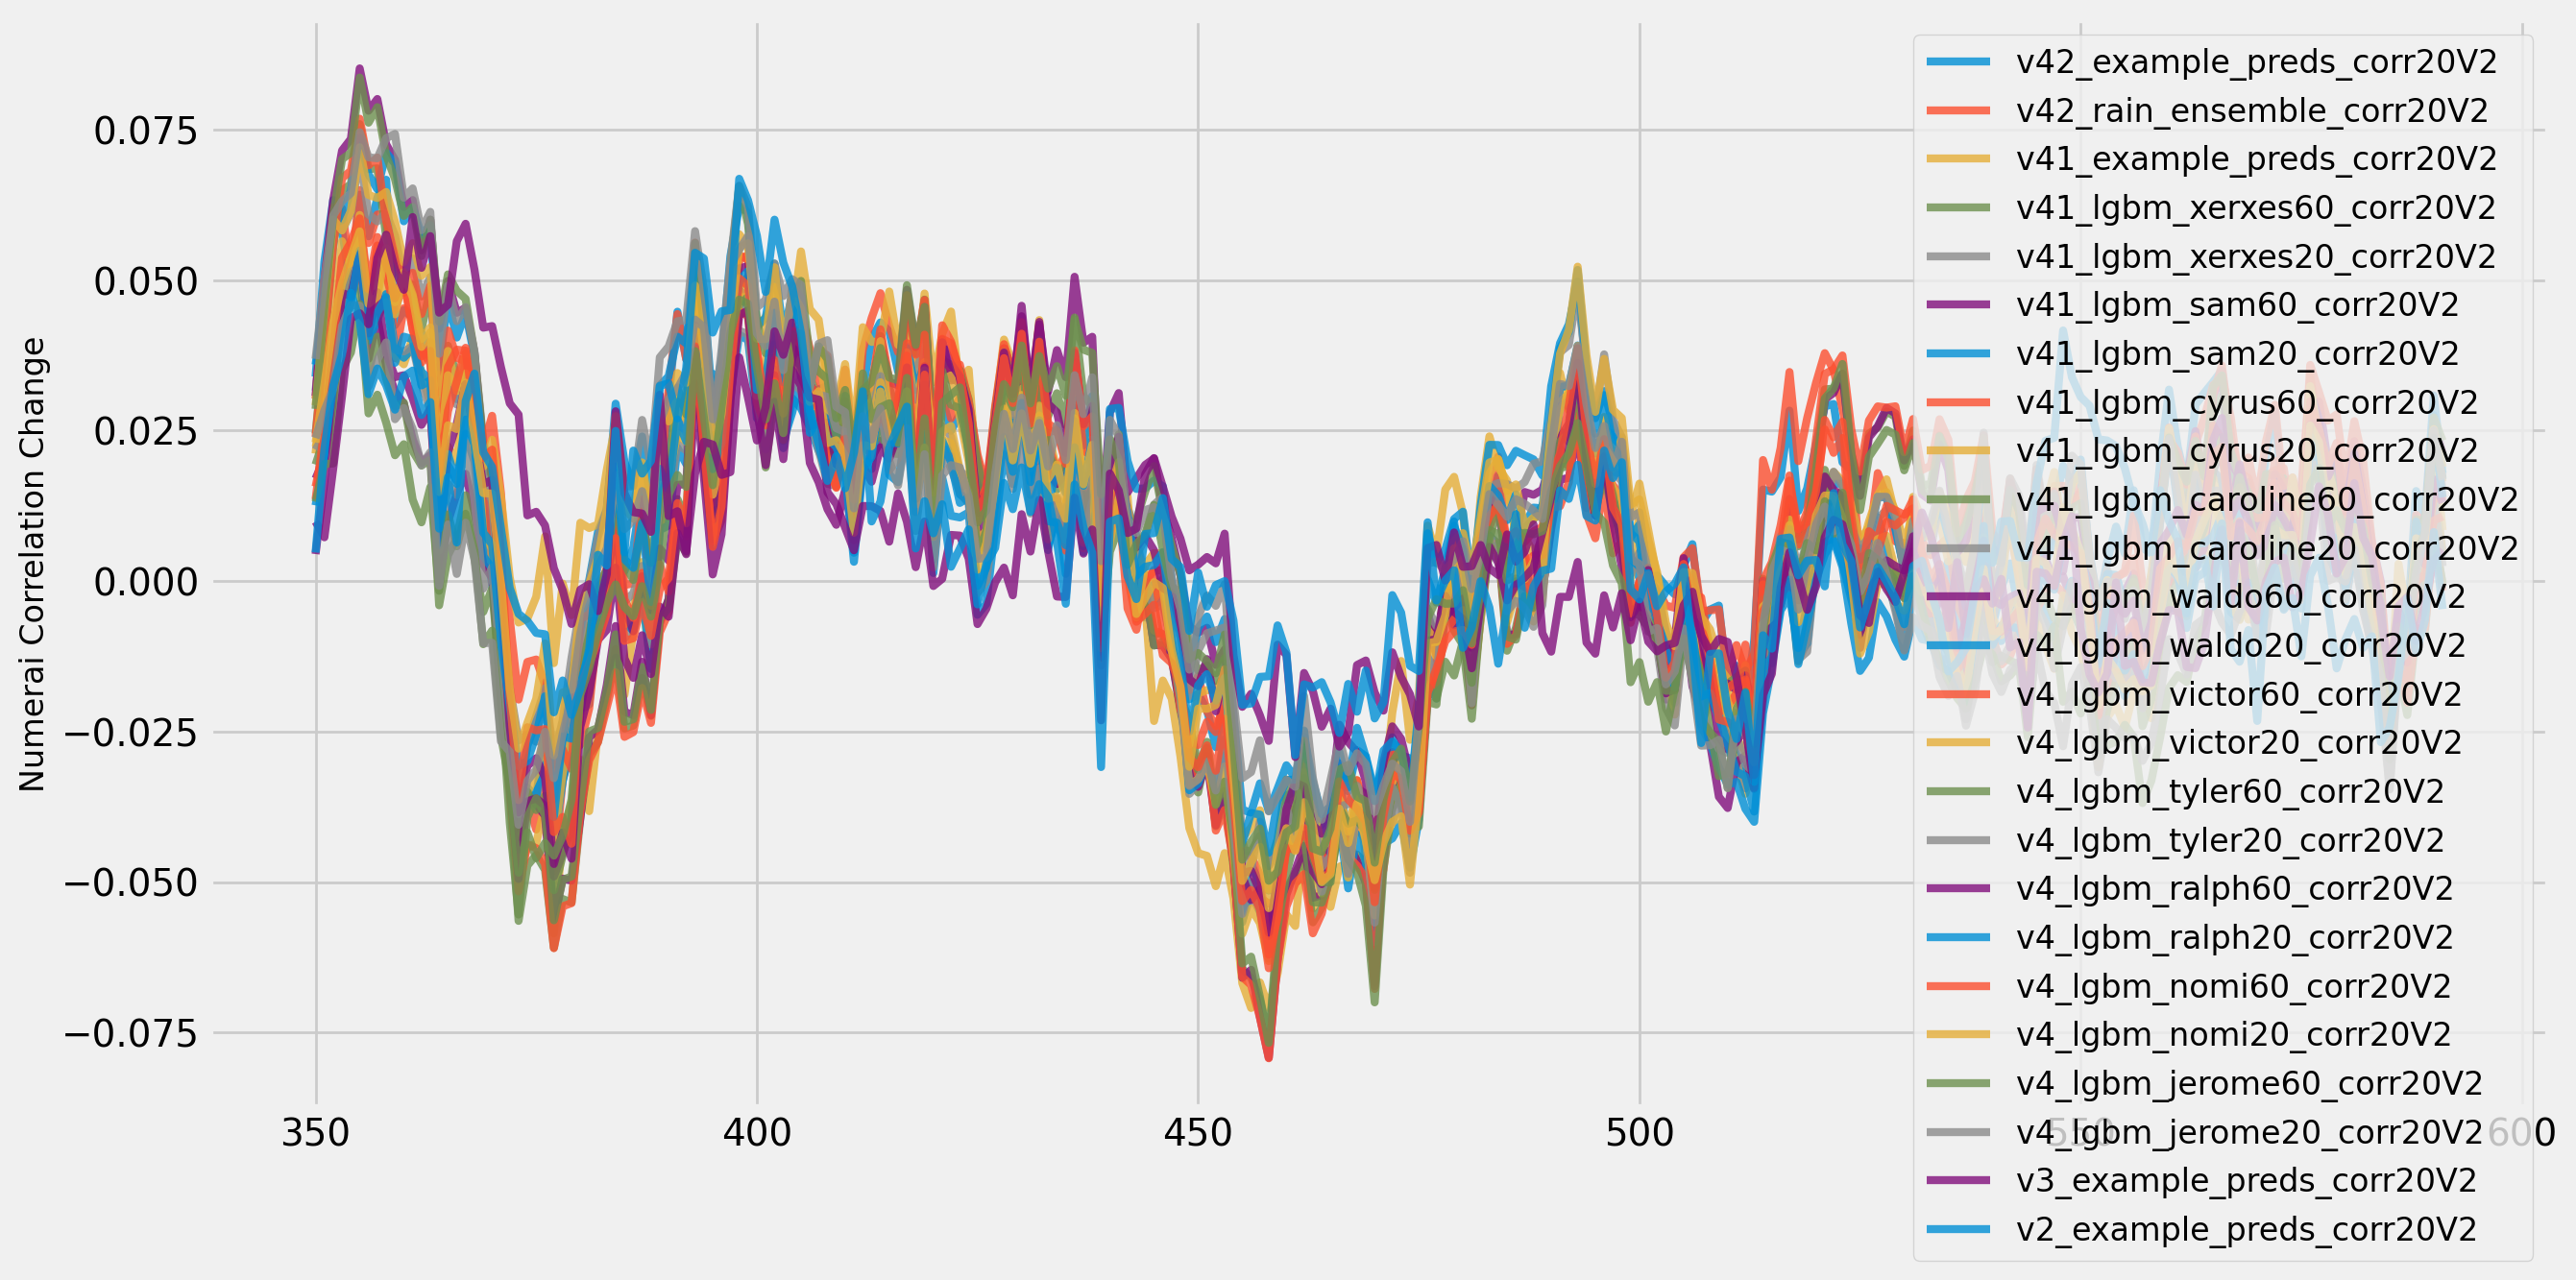

In [48]:
# Plot the corr change over time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

corr_cols=[col for col in metrics_summary_final.columns if col.endswith('_corr20V2')]
corr_returns = metrics_summary_final[corr_cols]
plt.figure(figsize=(14, 7))
for c in corr_returns.columns.values:
    plt.plot(corr_returns.index, corr_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Numerai Correlation Change', fontsize=12)

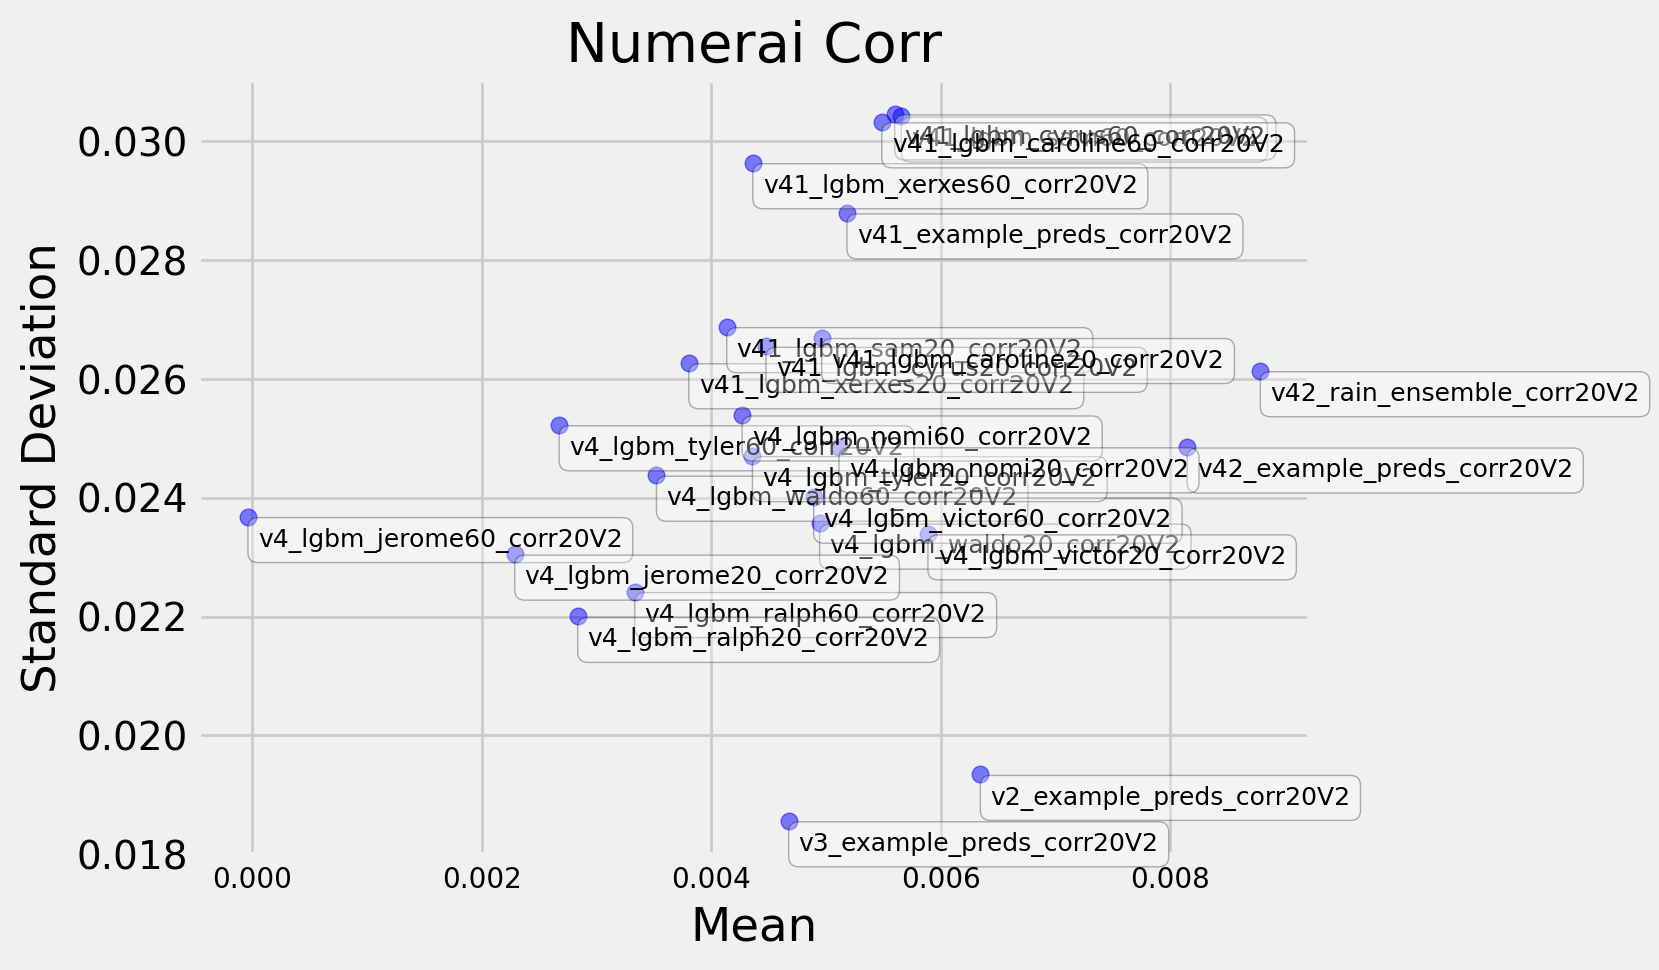

In [49]:
# Plot a scatterplot for all models' mean vs. standard deviation
metric_name='Numerai Corr'
all_mean=corr_returns.mean(axis=0)
all_std=corr_returns.std(axis=0)
temp_df=pd.concat([all_mean,all_std],axis=1).rename({0:'mean',1:'std'},axis=1)

import matplotlib.pyplot as plt
plt.scatter(all_mean, all_std,
            color='blue', alpha=0.5)

for i, model_name in enumerate(temp_df.index):
    plt.annotate(model_name, 
                (all_mean[i], all_std[i]),
                 xytext=(10,-30),textcoords='offset pixels',fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.3),
                )
    
# Add axis labels and title
plt.xlabel(f'Mean')
plt.ylabel('Standard Deviation')
plt.xticks(fontsize=10, rotation=0)
plt.title(f'{metric_name}')

# Display the plot
plt.show()

## True Contribution

Text(0, 0.5, 'Numerai Correlation Change')

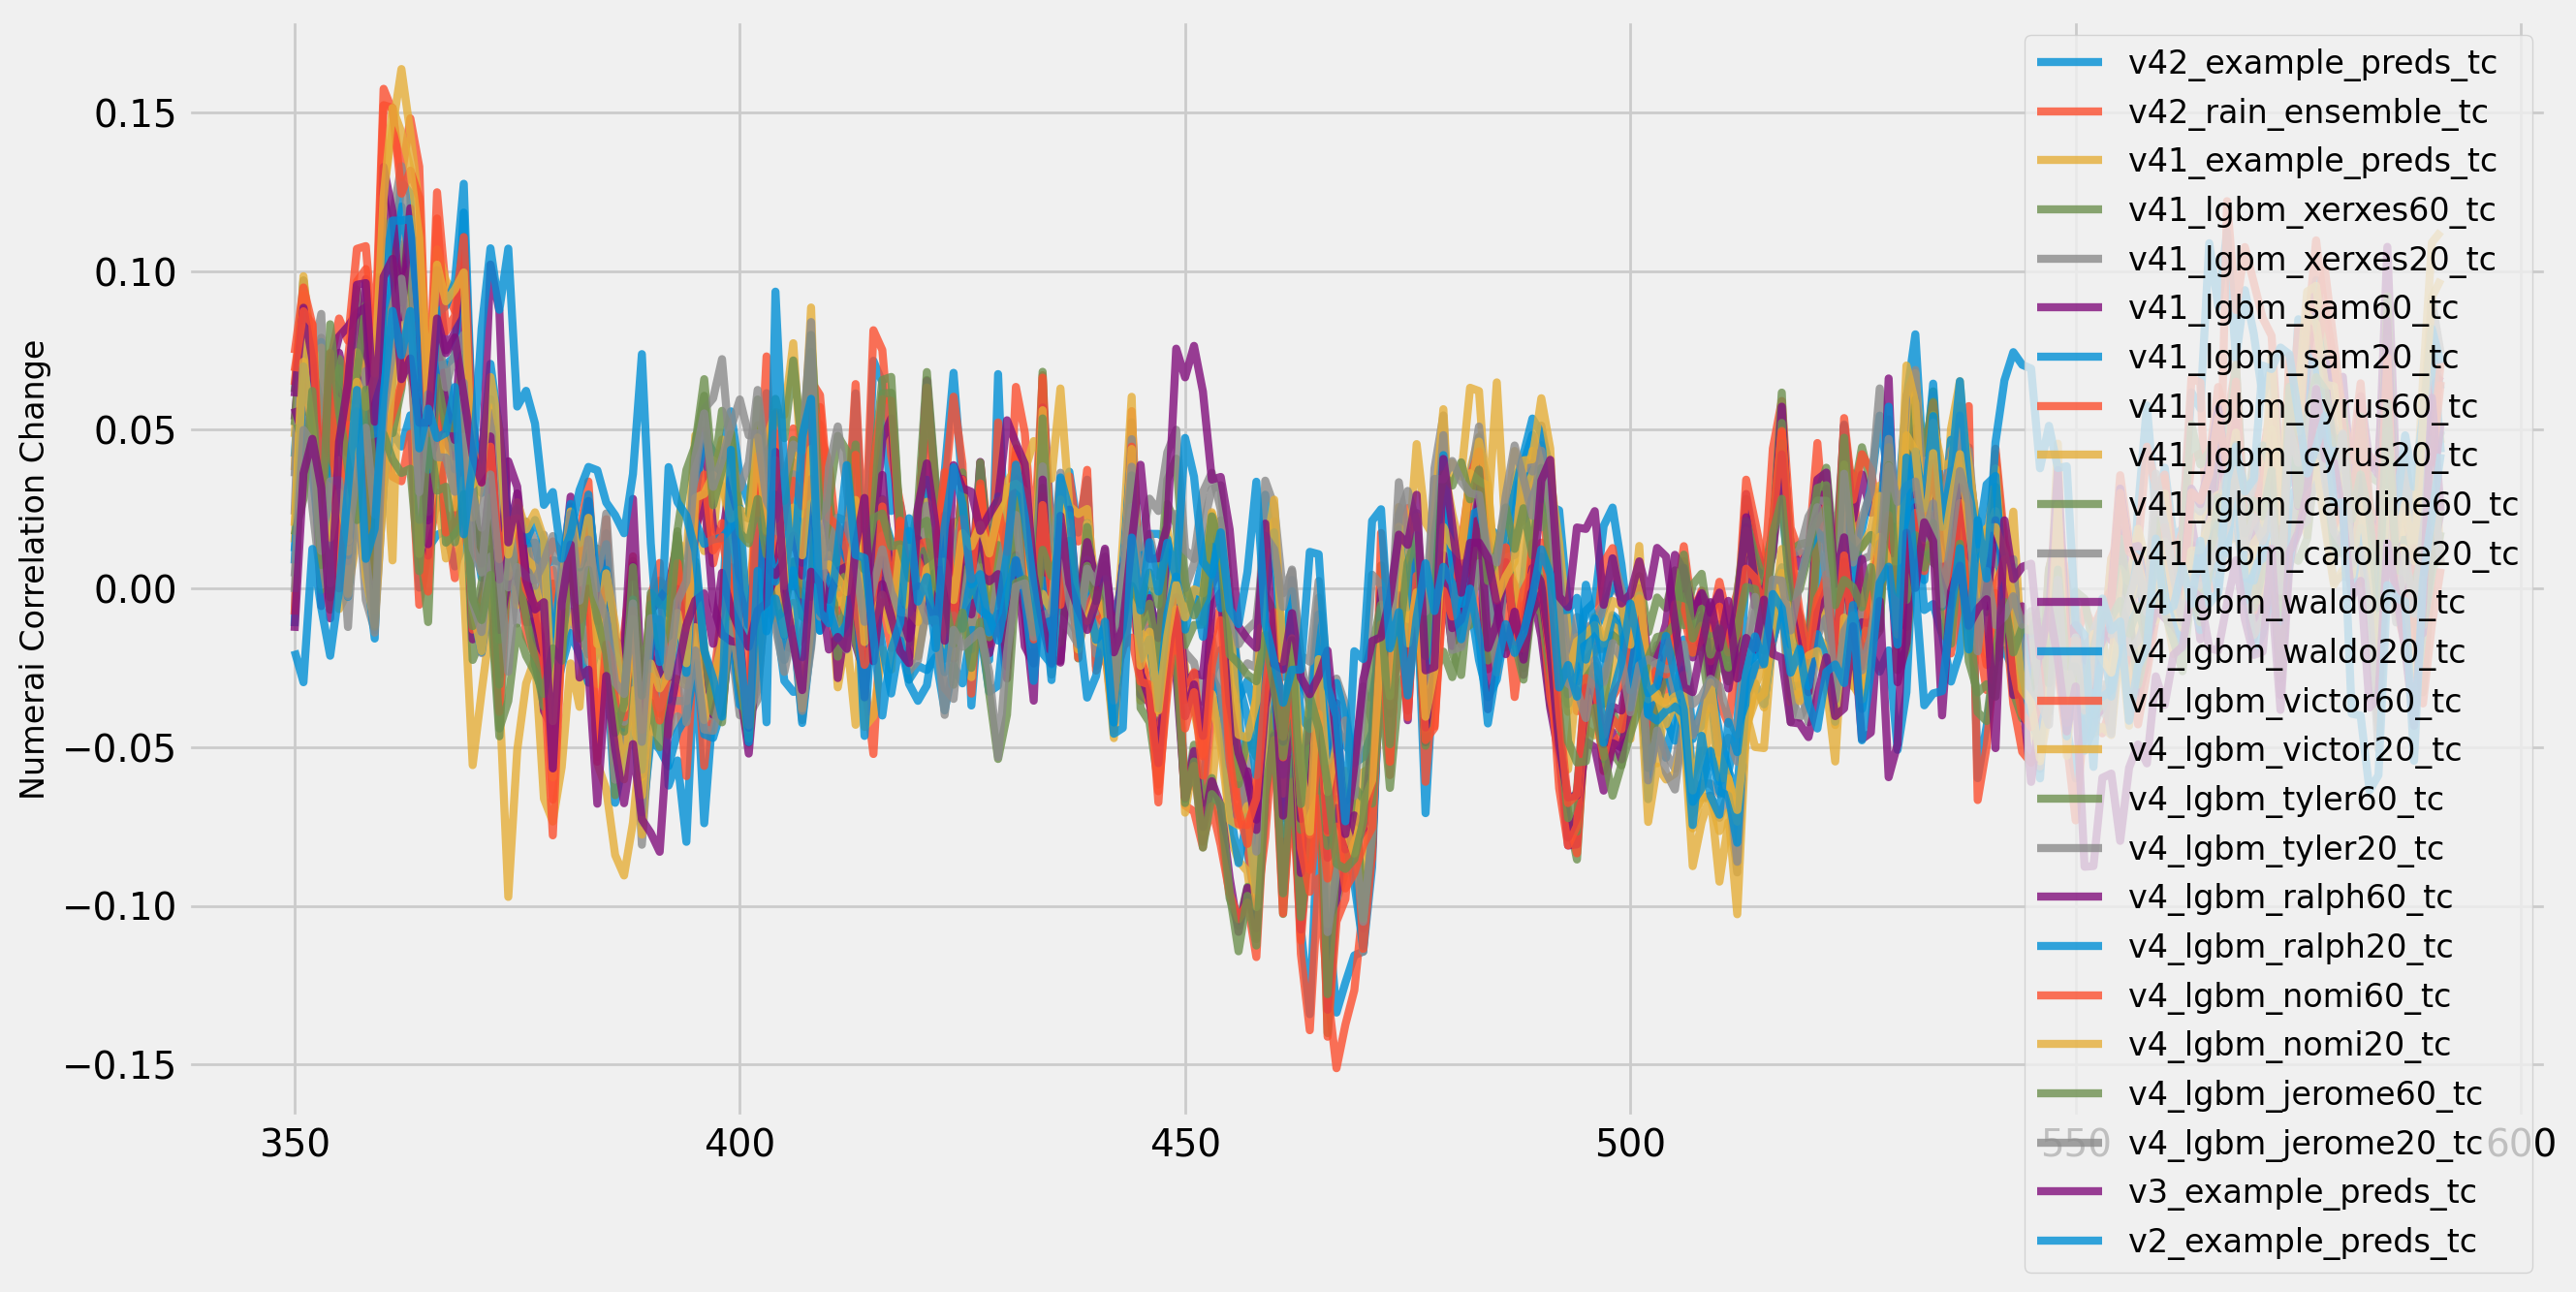

In [50]:
# Plot the corr change over time
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tc_cols=[col for col in metrics_summary_final.columns if col.endswith('_tc')]
tc_returns = metrics_summary_final[tc_cols]
plt.figure(figsize=(14, 7))
for c in tc_returns.columns.values:
    plt.plot(tc_returns.index, tc_returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('Numerai Correlation Change', fontsize=12)

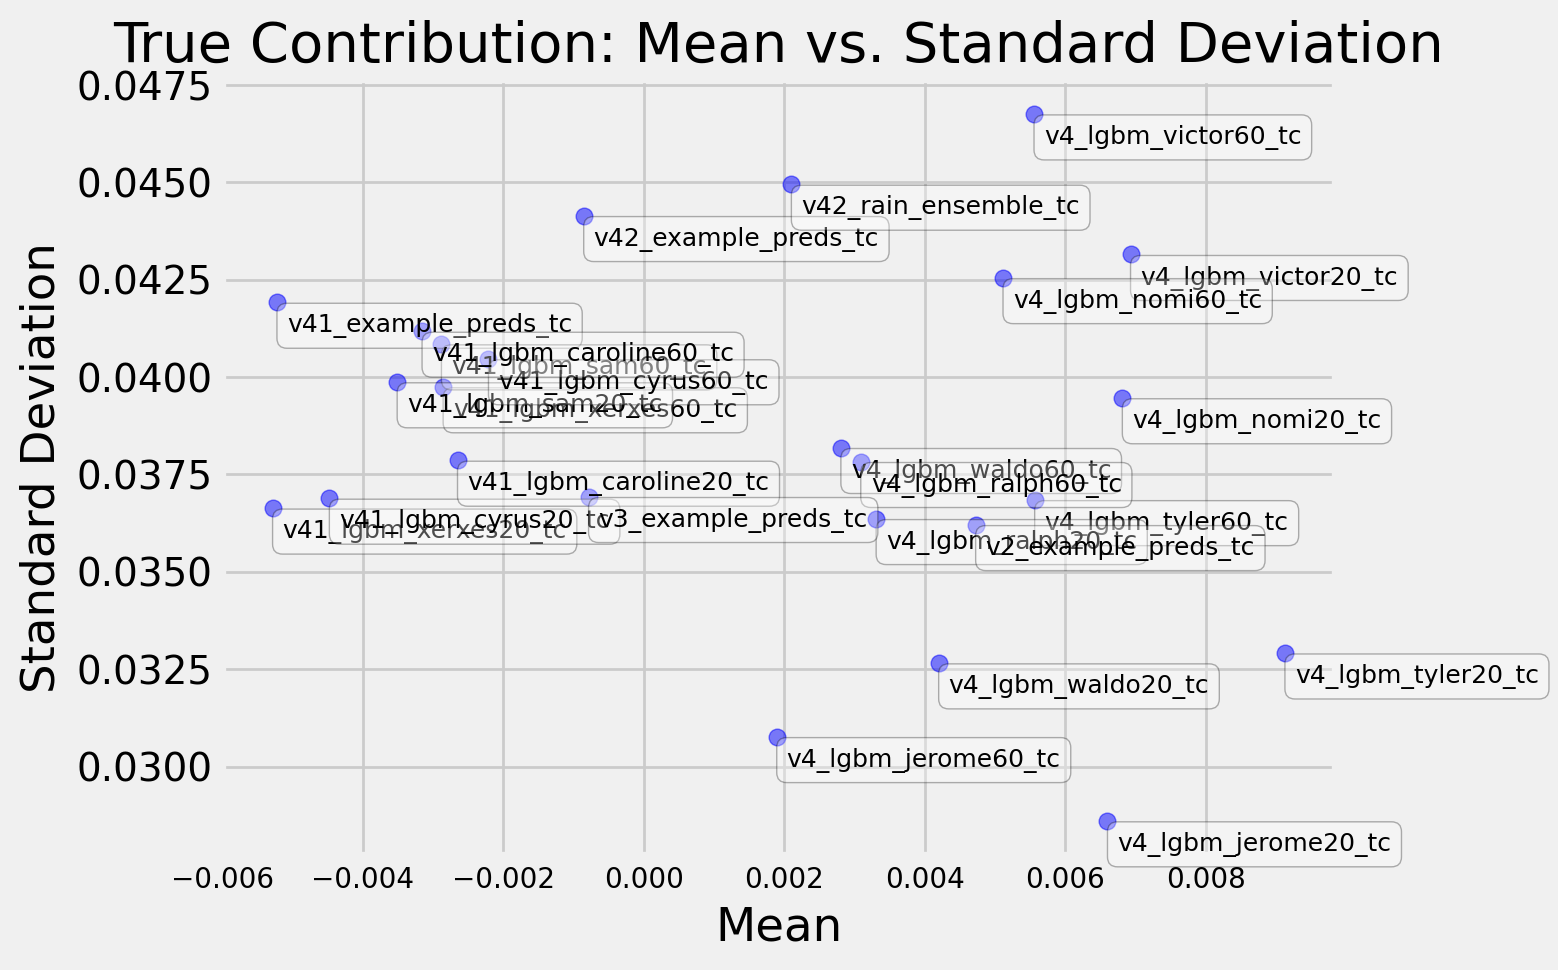

In [51]:
# Plot a scatterplot for all models' mean vs. standard deviation
metric_name='True Contribution'
all_mean=tc_returns.mean(axis=0)
all_std=tc_returns.std(axis=0)
temp_df=pd.concat([all_mean,all_std],axis=1).rename({0:'mean',1:'std'},axis=1)

import matplotlib.pyplot as plt
plt.scatter(all_mean, all_std,
            color='blue', alpha=0.5)

for i, model_name in enumerate(temp_df.index):
    plt.annotate(model_name, 
                (all_mean[i], all_std[i]),
                 xytext=(10,-30),textcoords='offset pixels',fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.4', fc='white', ec='black', alpha=0.3),
                )
    
# Add axis labels and title
plt.xlabel(f'Mean')
plt.ylabel('Standard Deviation')
plt.xticks(fontsize=10, rotation=0)
plt.title(f'{metric_name}: Mean vs. Standard Deviation')

# Display the plot
plt.show()

# Generate portfolio and plot Efficient Frontier

In [66]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    '''
    Calculates the annualized returns and volatility (standard deviation) of a portfolio, by each model's weights
    - Assumes portfolio will compound over the year, 52 weeks per year, 5 rounds per week
    '''
    returns = np.sum(mean_returns*weights) *52*5 #52 weeks per year, 5 rounds per week
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(52*5)
    return std, returns

def calculate_return_mean_conv(raw_metrics_df, model_list, multipliers, payout_factor=0.1):
    '''
    Calculates the mean returns and covariance matrix of the models, based on each model's corr and tc multipliers
    - raw_metrics_df: the raw metrics dataframe
    - model_list: list of models to be included in the portfolio
    - multipliers: array of multipliers for each model's corr->multipliers[0] and tc->multipliers[1]
    - payout_factor: payout factor for the tournament, at current daily rounds, it's ~0.1
    '''
    
    corr_cols=[model+'_corr20V2' for model in model_list]
    corr_return=(raw_metrics_df[corr_cols]*multipliers[0]).rename({col:col.replace('_corr20V2','') for col in corr_cols},axis=1)
    
    tc_cols=[model+'_tc' for model in model_list]
    tc_return=(raw_metrics_df[tc_cols]*multipliers[1]).rename({col:col.replace('_tc','') for col in tc_cols},axis=1)
    
    total_return=np.add(corr_return,tc_return)*payout_factor
    mean_returns=total_return.mean()
    cov_matrix=total_return.cov()
    return mean_returns, cov_matrix
  
def random_portfolios(raw_metrics_df, model_list, num_portfolios, risk_free_rate, rand_multiplier=True):
    '''
    Generates N random portfolios with randomized weights for each model
    - model_list: list of models to be included in the portfolio
    - num_portfolios: number of simulated portfolios to be generated
    - risk_free_rate: risk free rate, for Sharpe ratio calculation, can set to 0 if not needed
    - rand_multiplier: whether to randomize the multipliers for each model's corr and tc
    '''
    results = np.zeros((3,num_portfolios))
    weights_record = []
    multiplier_record=[]
    
    corr_multipliers=[0.5,1,1.5,2] # Nov 2023: Available staking options are 0 - 2, with 0.5 interval, removed 0 for more actionable conclusion
    tc_multipliers=[0,0.5,1] # Nov 2023: Available staking options are 0 - 1, with 0.5 interval
    
    model_count=len(model_list)
    
    for i in range(num_portfolios):
        # Generate random weights by no. of models
        weights = np.random.random(model_count) # generate random weights by no. of models
        weights /= np.sum(weights)
        weights = np.round(weights/0.01)*0.01 # round to nearest integer
        weights_record.append(weights)
        
        # Calculate each portfolio's annualized return and volatility (standard dev.)
        if rand_multiplier:
            # Pick random multipliers for each of corr/TC
            multipliers=(np.random.choice(corr_multipliers,size=model_count),
                         np.random.choice(tc_multipliers,size=model_count))
            multiplier_record.append(multipliers)
            # Calculate the mean returns and covariance matrix based on the random multipliers
            
        else:
            # If do not randomize, default corr multiplier=>1, TC multiplier=>0
            multipliers=(np.ones(model_count),
                         np.zeros(model_count))
            multiplier_record.append(multipliers)
        # Calculate the mean returns and covariance matrix based on the given multipliers
        mean_returns, cov_matrix= calculate_return_mean_conv(raw_metrics_df,model_names,multipliers)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        
        # Store the portfolio's standard dev
        results[0,i] = portfolio_std_dev
        # Store portfolio's return
        results[1,i] = portfolio_return
        # Store portfolio's Sharp ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
        
        # Verbose
        #if i%10000==0:
        #    print(i)
    return results, weights_record, multiplier_record

In [67]:
def display_simulated_ef_with_random(raw_metrics_df, model_list, num_portfolios, risk_free_rate, rand_multiplier=True):
    '''
    Plot the Efficient Frontier with random portfolios, return array of results, weights and multipliers
    '''
    results, weights_record, multiplier_record = random_portfolios(raw_metrics_df, model_list, num_portfolios, risk_free_rate, rand_multiplier=rand_multiplier)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(zip(weights_record[max_sharpe_idx],multiplier_record[max_sharpe_idx][0],multiplier_record[max_sharpe_idx][1]),
                                         index=model_list, 
                                         columns=['allocation_percent','corr_multiplier','tc_multiplier'])    
    max_sharpe_allocation.allocation_percent = [round(i*100,2)for i in max_sharpe_allocation.allocation_percent]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(zip(weights_record[min_vol_idx],multiplier_record[min_vol_idx][0],multiplier_record[min_vol_idx][1]),
                                      index=model_list, 
                                      columns=['allocation_percent','corr_multiplier','tc_multiplier'])
    min_vol_allocation.allocation_percent = [round(i*100,2)for i in min_vol_allocation.allocation_percent]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum Volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Returns')
    plt.legend(labelspacing=0.8)
    return results, weights_record, multiplier_record

In [68]:
#metrics_summary_final

In [72]:
# Currently only support _corr or _tc only
corr_cols = [col for col in metrics_summary_final.columns if col.endswith('_corr20V2')]
tc_cols = [col for col in metrics_summary_final.columns if col.endswith('_tc')]
num_portfolios = 50000 # Suggested to be number_of_models *10000
risk_free_rate = 0 #0.01 # For Sharpe ratio calculation
raw_metrics_df=metrics_summary_final


In [73]:
len(model_names)

25

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.2
Annualised Volatility: 0.05


                    v42_example_preds  v42_rain_ensemble  v41_example_preds  v41_lgbm_xerxes60  v41_lgbm_xerxes20  v41_lgbm_sam60  v41_lgbm_sam20  v41_lgbm_cyrus60  v41_lgbm_cyrus20  v41_lgbm_caroline60  v41_lgbm_caroline20  v4_lgbm_waldo60  v4_lgbm_waldo20  v4_lgbm_victor60  v4_lgbm_victor20  v4_lgbm_tyler60  v4_lgbm_tyler20  v4_lgbm_ralph60  v4_lgbm_ralph20  v4_lgbm_nomi60  v4_lgbm_nomi20  v4_lgbm_jerome60  v4_lgbm_jerome20  v3_example_preds  v2_example_preds
allocation_percent                7.0                5.0                0.0                1.0                2.0             6.0             0.0               6.0               0.0                  3.0                  6.0              1.0              2.0               3.0               9.0              7.0              6.0              5.0             

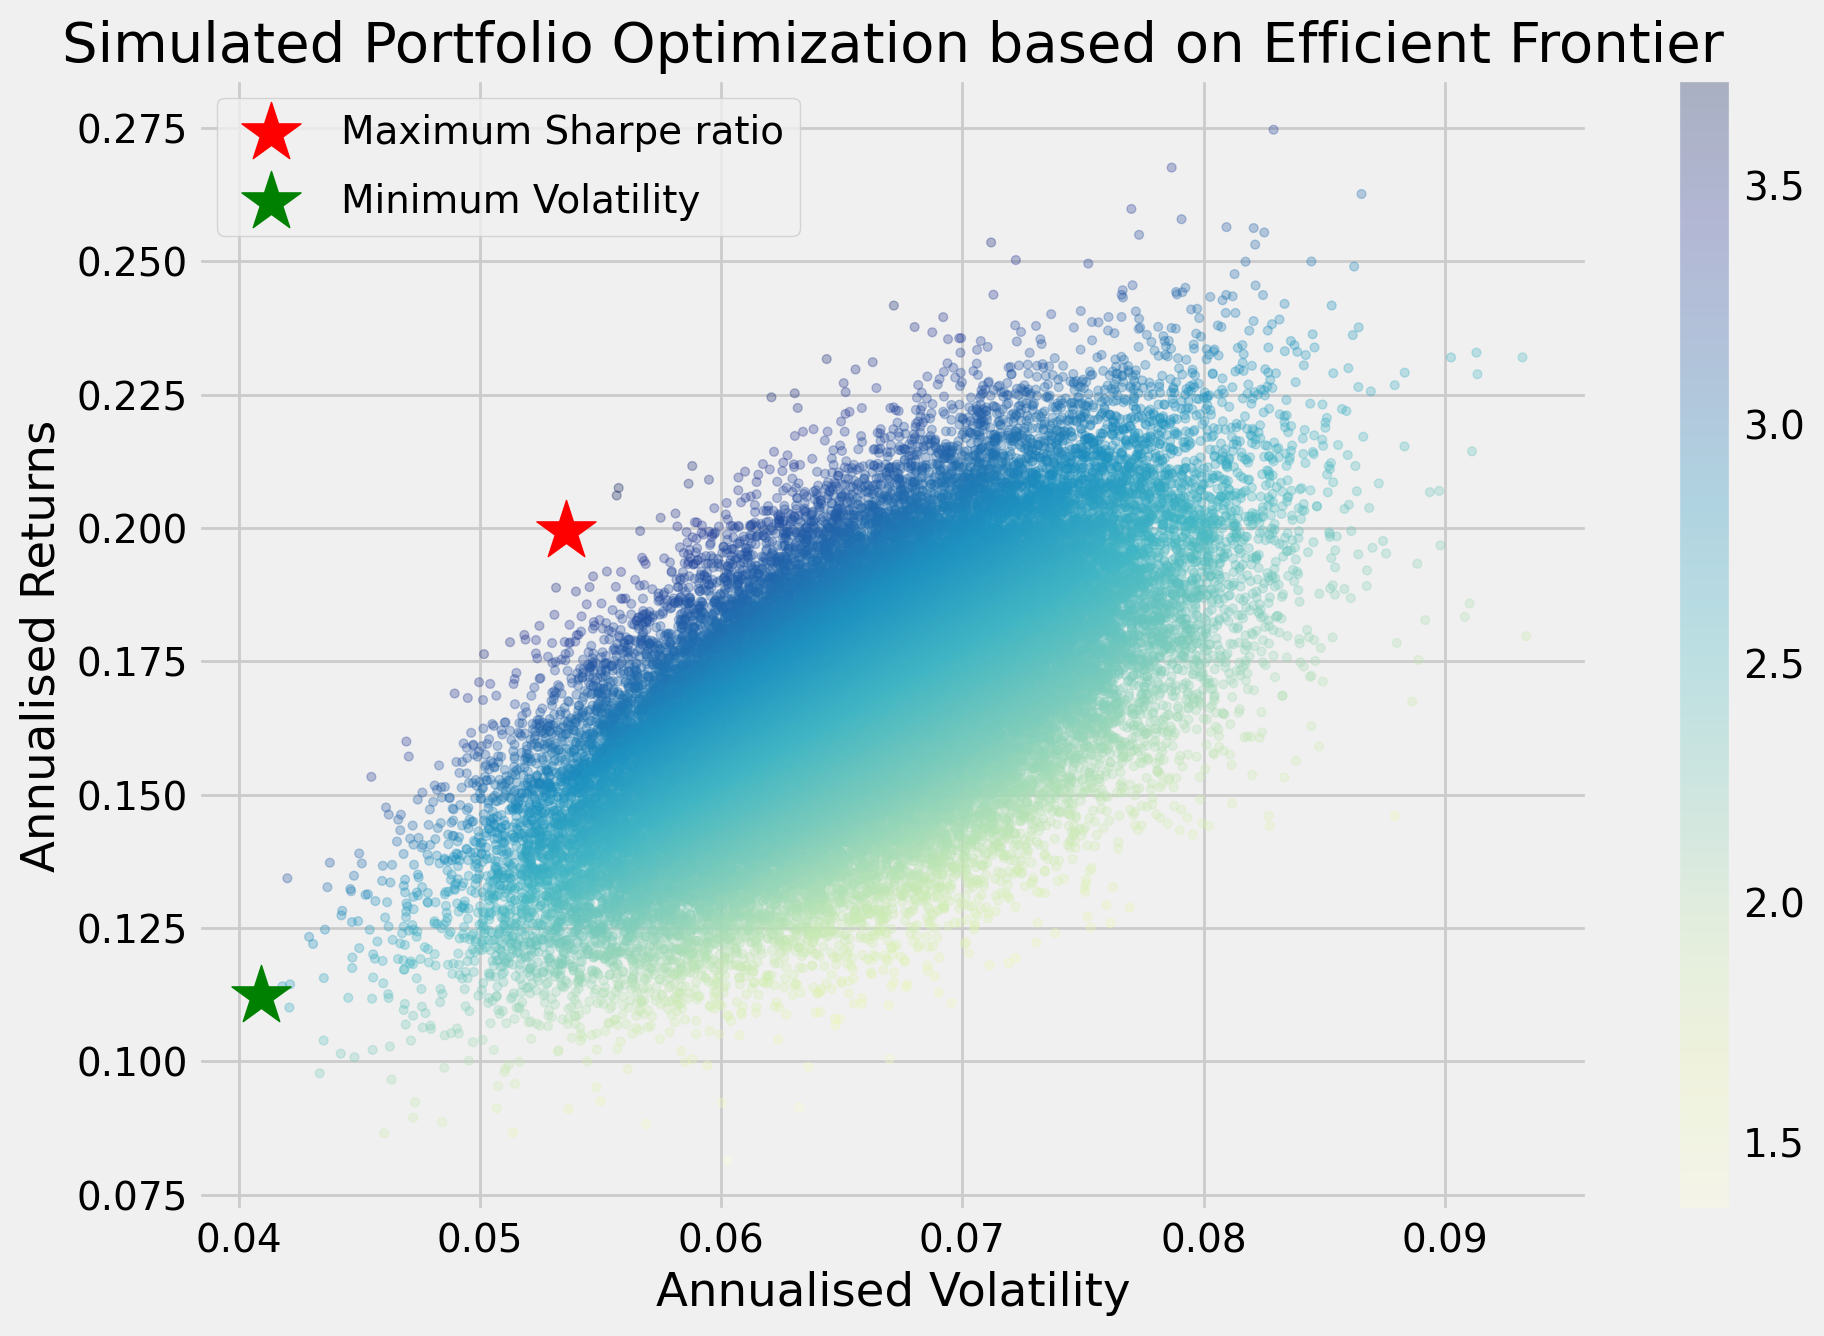

In [74]:
# Plot the efficient frontier for the simulated portfolios
results, weights_record, multiplier_record = display_simulated_ef_with_random(raw_metrics_df, model_names, num_portfolios, risk_free_rate, rand_multiplier=True)

Work-in-progress, create table to sort and select models by
- Max Sharpe Ratio
- Max Return
- Min Volatility

In [34]:
max_sharpe_idx_desc = sorted(range(len(results[2])), key=lambda i: results[2][i], reverse=True)
max_return_idx_desc = sorted(range(len(results[1])), key=lambda i: results[1][i], reverse=True)
min_vol_idx_desc = sorted(range(len(results[0])), key=lambda i: results[0][i], reverse=False)